## Graph Neural Network for Molecular Interaction Prediction

This Jupyter Notebook outlines the process for training a Graph Neural Network (GNN) model to predict molecular interactions using the GATv2 architecture. The goal of this project is to leverage the inherent graph structure of molecules for effective prediction of binding to RNA, a crucial factor in drug discovery and biological research.

Each run of this notebook represents a distinct experiment with specified hyperparameters and configurations. Results and models from each run are saved separately for comparative analysis to ensure the reproducibility and statistical significance of our findings.

### Notebook Details:

- **Objective**: Predict molecular interactions with RNA using GNN.
- **Model Architecture**: GATv2Conv from the Deep Graph Library (DGL).
- **Data Source**: Preprocessed molecular interaction datasets.
- **Run Number**: This notebook facilitates multiple runs. Specific details for each run, including the random state and run number, are set at the beginning to ensure reproducibility.

Before executing the notebook, please adjust the `RANDOM_STATE` and `RUN_NUMBER` variables at the top of the notebook to reflect the specific experiment being conducted. This setup ensures each run's outputs are unique and traceable.


In [1]:
"""
This script implements a Graph Neural Network (GNN) using the GATv2 architecture
for the purpose of predicting molecular interactions. The implementation leverages
the Deep Graph Library (DGL) for constructing and manipulating graphs, as well as
Optuna for hyperparameter optimization. The model includes features such as dropout,
early stopping, and gradient scaling for improved training stability and performance.
"""


'\nThis script implements a Graph Neural Network (GNN) using the GATv2 architecture\nfor the purpose of predicting molecular interactions. The implementation leverages\nthe Deep Graph Library (DGL) for constructing and manipulating graphs, as well as\nOptuna for hyperparameter optimization. The model includes features such as dropout,\nearly stopping, and gradient scaling for improved training stability and performance.\n'

In [2]:
# Set the random seed and run number at the top for reproducibility and to differentiate runs
RANDOM_STATE = 555
RUN_NUMBER = 7

import numpy as np
import torch
import dgl

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
dgl.seed(RANDOM_STATE)


## Import Necessary Libraries

In [3]:
import os
import sys
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import dgl
from dgl.nn import GATv2Conv, GlobalAttentionPooling
from dgl.dataloading import GraphDataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import optuna
from optuna.pruners import MedianPruner
from torch.cuda.amp import GradScaler, autocast


## The Graph Neural Network Model



In [4]:
class GraphClsGATv2(nn.Module):

    def __init__(self, 
                 in_feats, 
                 hidden_dim, 
                 num_heads, 
                 num_cls,
                 negative_slope, 
                 dropout_rate, 
                 ):
        super(GraphClsGATv2, self).__init__()
        
        self.layer1 = GATv2Conv(in_feats, 
                                hidden_dim, 
                                num_heads=num_heads, 
                                attn_drop=dropout_rate,
                                feat_drop=dropout_rate, 
                                negative_slope=negative_slope,
                                residual=True)
        self.layer2 = GATv2Conv(hidden_dim * num_heads, 
                                hidden_dim, num_heads=1, 
                                attn_drop=dropout_rate,
                                feat_drop=dropout_rate, 
                                negative_slope=negative_slope,
                                residual=True)
        
        self.pooling = GlobalAttentionPooling(gate_nn=nn.Linear(hidden_dim, 1))
        
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim, num_cls)
        
        self.norm1 = nn.LayerNorm(hidden_dim * num_heads)
        self.norm2 = nn.LayerNorm(hidden_dim)


    def forward(self, g, h):
        h = F.elu(self.layer1(g, h).flatten(1))
        h = self.norm1(h)
        h = F.elu(self.layer2(g, h).flatten(1))
        h = self.norm2(h)
        h = self.dropout(h)
        
        hg = self.pooling(g, h)
        out = self.fc(hg)
        
        return out


    def reset_parameters(self):
        for layer in self.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

## Early Stopping Mechanism



In [5]:
class EarlyStopping:
    """Early stops the training if neither validation loss nor validation 
    accuracy improves after their respective patience levels.
    
    Parameters
    ----------
    patience_loss : int
        How long to wait after last time validation loss improved.
    patience_accuracy : int
        How long to wait after last time validation accuracy improved.
    verbose : bool
        If True, prints a message for each validation metric improvement.
    delta_loss : float
        Minimum change in the validation loss to qualify as an improvement.
    delta_accuracy : float
        Minimum change in the validation accuracy to qualify as an improvement.
    path : str
        The file path where the model will be saved.
    print_freq : int
        The frequency at which to print messages during training.
    """

    def __init__(
            self,
            patience_loss=10,
            patience_accuracy=10,
            verbose=True,
            delta_loss=0.001,
            delta_accuracy=0.001,
            path='checkpoint.pt',
            print_freq=5):
        self.patience_loss = patience_loss
        self.patience_accuracy = patience_accuracy
        self.verbose = verbose
        self.counter_loss = 0
        self.counter_accuracy = 0
        self.best_loss = np.Inf
        self.best_accuracy = 0
        self.early_stop = False
        self.delta_loss = delta_loss
        self.delta_accuracy = delta_accuracy
        self.path = path
        self.best_epoch = 0
        self.print_freq = print_freq
        
    def __call__(self, val_loss, val_accuracy, model, epoch):
        improved_loss = False
        improved_accuracy = False
        
        # Check improvement for loss
        if val_loss < self.best_loss - self.delta_loss:
            self.best_loss = val_loss
            self.counter_loss = 0
            improved_loss = True
        else:
            self.counter_loss += 1
        
        # Check improvement for accuracy
        if val_accuracy > self.best_accuracy + self.delta_accuracy:
            self.best_accuracy = val_accuracy
            self.counter_accuracy = 0
            improved_accuracy = True
        else:
            self.counter_accuracy += 1
        
        # Save checkpoint if either metric improved
        if improved_loss or improved_accuracy:
            self.save_checkpoint(val_loss, val_accuracy, model)
            self.best_epoch = epoch
        
        if self.verbose and (improved_loss or improved_accuracy):
            print(f"Improvement at epoch {epoch}: Loss = {val_loss}, "
                f"Accuracy = {val_accuracy}")
        
        # Determine if early stopping is triggered
        if self.counter_loss >= self.patience_loss and \
            self.counter_accuracy >= self.patience_accuracy:
            self.early_stop = True
            if self.verbose:
                print("Early stopping triggered")
                
    def save_checkpoint(self, val_loss, val_accuracy, model):
        # Implement saving logic based on your requirements
        torch.save(model.state_dict(), self.path)
        if self.verbose:
            print(f"Checkpoint saved: Loss = {val_loss}, "
                  f"Accuracy = {val_accuracy}")



## The Collate Function for DataLoader



In [6]:
def collate(samples):
    """
    Function to collate samples into a batch for the GraphDataLoader.
    
    Parameters
    ----------
    samples : list
        A list of tuples of the form (graph, label).
    """
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    labels = torch.tensor(labels, dtype=torch.long)
    return batched_graph, labels


## Training and Evaluation Pipeline


In [7]:
class TrainingPipeline:
    def __init__(self, device):
        self.device = device

    def train_and_evaluate(
            self,
            model,
            train_loader,
            val_loader,
            optimizer,
            criterion,
            early_stopping,
            num_epochs,
            plot_curves=False,
            accumulation_steps=2):
        train_losses, val_losses = [], []
        scaler = GradScaler()  # Initialize the gradient scaler

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0
            optimizer.zero_grad()  # Initialize gradients to zero

            for batch_idx, (batched_graph, labels) in enumerate(train_loader):
                batched_graph, labels = batched_graph.to(
                    self.device), labels.to(self.device)

                with autocast():  # Enable automatic mixed precision
                    logits = model(
                        batched_graph, batched_graph.ndata['h'].float())
                    loss = criterion(logits, labels) / \
                        accumulation_steps  # Scale loss

                # Scale the loss and call backward to propagate gradients
                scaler.scale(loss).backward()
                # Correct scaling for logging purposes
                train_loss += loss.item() * accumulation_steps

                if (batch_idx + 1) % accumulation_steps == 0 or \
                        batch_idx == len(train_loader) - 1:
                    # Perform optimizer step using scaled gradients
                    scaler.step(optimizer)
                    scaler.update()  # Update the scaler for the next iteration
                    optimizer.zero_grad()  # Initialize gradients to zero

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            val_loss = 0.0
            val_accuracy = 0.0
            val_correct = 0
            total = 0
            if val_loader is not None:
                model.eval()
                with torch.no_grad():
                    val_correct = 0
                    total = 0
                    for batched_graph, labels in val_loader:
                        batched_graph, labels = batched_graph.to(
                            self.device), labels.to(self.device)
                        with autocast():  # Enable automatic mixed precision
                            logits = model(
                                batched_graph, batched_graph.ndata['h'].float()
                            )
                            loss = criterion(logits, labels)
                        val_loss += loss.item()
                        _, predicted = torch.max(logits.data, 1)
                        total += labels.size(0)
                        val_correct += (predicted == labels).sum().item()

                    val_loss /= len(val_loader)
                    val_losses.append(val_loss)
                    val_accuracy = val_correct / total
                    
                    # here will be early stopping
                    if early_stopping:
                        early_stopping(val_loss, val_accuracy, model, epoch + 1)
                        if early_stopping.early_stop:
                            print(
                                f"Early stopping triggered"
                                f"at epoch {epoch + 1}")
                            break

                if (epoch + 1) % 5 == 0 or epoch == 0:
                    print(
                        f'Epoch {epoch + 1}/{num_epochs} - '
                        f'Train Loss: {train_loss:.4f}, '
                        f'Val Loss: {val_loss:.4f} '
                        f'| Val accuracy: {100 * val_accuracy:.2f}%')

        if plot_curves and val_loader is not None:
            self.plot_loss_curves(train_losses, val_losses)

    @staticmethod
    def plot_loss_curves(train_losses, val_losses):
        sns.set(style="whitegrid")
        plt.figure(figsize=(10, 6))
        epochs = range(1, len(train_losses) + 1)
        plt.plot(epochs, train_losses, label='Training Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.title('Training and Validation Loss of GATv2Conv')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f'loss_curves_{RUN_NUMBER}.png', dpi=300)
        plt.show()

    def evaluate_on_test(self, model, test_loader, criterion, run_id):
        model.eval()
        test_loss = 0.0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batched_graph, labels in test_loader:
                batched_graph, labels = batched_graph.to(self.device), labels.to(self.device)
                logits = model(batched_graph, batched_graph.ndata['h'].float())
                loss = criterion(logits, labels)
                test_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss /= len(test_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds)
        recall = recall_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds)
        roc_auc = roc_auc_score(all_labels, all_preds)

        # Calculate and save confusion matrix
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.savefig(f'confusion_matrix_{run_id}.png', dpi=300)

        # Append results to CSV including added metrics
        results_df = pd.DataFrame({
            'Run ID': [run_id],
            'Test Loss': [test_loss],
            'Accuracy': [accuracy],
            'Precision': [precision],
            'Recall': [recall],
            'F1-Score': [f1],
            'ROC-AUC': [roc_auc]
        })
        results_df.to_csv('test_results_GATv2Conv.csv', mode='a', index=False, 
                        header=not os.path.exists('test_results_GATv2Conv.csv'))

        print(f"Test Loss: {test_loss}")
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}, ROC-AUC: {roc_auc}")


## Hyperparameter Optimization Using Optuna



In [8]:
class HyperparameterOptimizer:
    def __init__(
            self,
            device,
            subset_train_graphs,
            subset_train_labels,
            subset_val_graphs,
            subset_val_labels,
            num_trials,
            num_epochs):
        self.device = device
        self.subset_train_graphs = subset_train_graphs
        self.subset_train_labels = subset_train_labels
        self.subset_val_graphs = subset_val_graphs
        self.subset_val_labels = subset_val_labels
        self.num_trials = num_trials
        self.num_epochs = num_epochs

    def objective(self, trial):
        # Adjusting the hyperparameters for GATv2Conv
        in_feats = 74  
        hidden_dim = trial.suggest_int('hidden_dim', 16, 256)
        num_heads = trial.suggest_categorical('num_heads', [1, 2, 3, 4, 5, 
                                                              6, 7, 8, 9, 10, 
                                                            12, 14, 16, 18, 20])
        dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5) 
        negative_slope = trial.suggest_float('negative_slope', 0.01, 0.2)
        lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
        batch_size = trial.suggest_categorical('batch_size', [64, 128, 256, 512])

        # Create the model, optimizer, and loaders
        model = GraphClsGATv2(
            in_feats=in_feats,
            hidden_dim=hidden_dim,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            negative_slope=negative_slope,
            num_cls=2,
        ).to(self.device)
        
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        train_loader = GraphDataLoader(
            list(zip(self.subset_train_graphs, self.subset_train_labels)),
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate,
            num_workers=8)
        val_loader = GraphDataLoader(
            list(zip(self.subset_val_graphs, self.subset_val_labels)),
            batch_size=batch_size,
            shuffle=False,
            collate_fn=collate,
            num_workers=8)

        # Training loop with pruning
        model.train()
        for epoch in range(self.num_epochs):
            for batched_graph, labels in train_loader:
                batched_graph, labels = batched_graph.to(
                    self.device), labels.to(self.device)
                optimizer.zero_grad()
                logits = model(batched_graph, batched_graph.ndata['h'].float())
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

            # Validation phase and report for pruning
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batched_graph, labels in val_loader:
                    batched_graph, labels = batched_graph.to(
                        self.device), labels.to(self.device)
                    logits = model(
                        batched_graph, batched_graph.ndata['h'].float())
                    loss = criterion(logits, labels)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            # Report intermediate value to the pruner
            trial.report(val_loss, epoch)

            if trial.should_prune():  # Handle pruning based on the 
                                      # intermediate value
                raise optuna.TrialPruned()

        return val_loss

    def optimize(self):
        """Run the hyperparameter optimization.
        
         Returns
         -------
         dict
             The best hyperparameters found by the optimization.
        """
        study = optuna.create_study(direction='minimize',
                                    pruner=MedianPruner())
        study.optimize(self.objective, n_trials=self.num_trials)

        best_hyperparams = study.best_trial.params
        with open(f'gatv2_best_hyperparams_run_{RUN_NUMBER}.json', 'w') as f:
            json.dump(best_hyperparams, f)
        print(f"Best hyperparameters are {best_hyperparams}.")
        print("Best hyperparameters saved.")
        

## Main Training Loop



In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [10]:
# Load data and prepare for training
graphs, labels_dict = dgl.load_graphs("../../../data_mvi/data_for_ml/dataset_set2/model2_rna_bin_protein_bin/graphs/graphs.bin")

# Directly extract labels tensor from labels_dict
labels_tensor = labels_dict['labels']
labels_tensor = labels_tensor.squeeze()

# Convert tensor to numpy array for compatibility with sklearn
labels_numpy = labels_tensor.numpy()

# Split dataset train, test
train_indices, test_indices, train_labels, test_labels = train_test_split(
    range(labels_dict['labels'].size(0)), labels_numpy, test_size=0.2, stratify=labels_numpy,
    random_state=RANDOM_STATE)

# Split dataset train, validation
train_indices, val_indices, train_labels, val_labels = train_test_split(
    train_indices, train_labels, test_size=0.2, stratify=train_labels,
    random_state=RANDOM_STATE)

# Placeholder for data loading. Replace this with your actual data loading
# code.
train_graphs = [graphs[i] for i in train_indices]
test_graphs = [graphs[i] for i in test_indices]
val_graphs = [graphs[i] for i in val_indices]

subset_train_indices = np.random.choice(
    len(train_graphs), size=int(len(train_graphs) * 1), replace=False)
subset_train_graphs = [train_graphs[i] for i in subset_train_indices]
subset_train_labels = train_labels[subset_train_indices]

subset_val_indices = np.random.choice(
    len(val_graphs), size=int(len(val_graphs) * 1), replace=False)
subset_val_graphs = [val_graphs[i] for i in subset_val_indices]
subset_val_labels = val_labels[subset_val_indices]

# Combine train and validation graphs and labels for retraining
combined_train_graphs = train_graphs + val_graphs
combined_train_labels = np.concatenate((train_labels, val_labels))

# annouce the start of the project
print("Starting the project...")
print("")

# annouce the start of the data loading
print("Starting data loading...")
print(
    f'Train: {len(train_graphs)}, Validation: {len(val_graphs)}, '
    f'Test: {len(test_graphs)}, \nSubset Train: {len(subset_train_graphs)}, '
    f'Subset Val: {len(subset_val_graphs)}'
)
print("")
print("Completed data loading.")
print("")
sys.stdout.flush()  # Force flushing of the buffer


Starting the project...

Starting data loading...
Train: 2509, Validation: 628, Test: 785, 
Subset Train: 2509, Subset Val: 628

Completed data loading.



## Perform Hyperparameter Optimization


In [11]:
# 1. Hyperparameter Optimization on a subset of the data
print("Starting hyperparameter optimization...")
sys.stdout.flush()
print("")

# Specify the number of trials and epochs for hyperparameter optimization
optimizer = HyperparameterOptimizer(
    device,
    subset_train_graphs,
    subset_train_labels,
    subset_val_graphs,
    subset_val_labels,
    num_trials=20,
    num_epochs=30)
optimizer.optimize()
print("Completed hyperparameter optimization.")
sys.stdout.flush()

print("")


Starting hyperparameter optimization...


[I 2024-05-01 21:47:04,116] A new study created in memory with name: no-name-b3df5f4b-3626-41f3-835e-4b230cd176ed


[I 2024-05-01 21:47:29,775] Trial 0 finished with value: 0.33289508521556854 and parameters: {'hidden_dim': 106, 'num_heads': 4, 'dropout_rate': 0.19208683505998753, 'negative_slope': 0.06741027177203117, 'lr': 0.0004417593969380136, 'batch_size': 512}. Best is trial 0 with value: 0.33289508521556854.


[I 2024-05-01 21:48:07,900] Trial 1 finished with value: 0.4509334146976471 and parameters: {'hidden_dim': 209, 'num_heads': 10, 'dropout_rate': 0.49453702042331193, 'negative_slope': 0.08975413404957049, 'lr': 0.07390517028118328, 'batch_size': 128}. Best is trial 0 with value: 0.33289508521556854.


[I 2024-05-01 21:48:45,715] Trial 2 finished with value: 0.37341692447662356 and parameters: {'hidden_dim': 218, 'num_heads': 10, 'dropout_rate': 0.3402932525552936, 'negative_slope': 0.12073939006088928, 'lr': 0.0030981230724691014, 'batch_size': 128}. Best is trial 0 with value: 0.33289508521556854.


[I 2024-05-01 21:49:16,723] Trial 3 finished with value: 0.3339444473385811 and parameters: {'hidden_dim': 165, 'num_heads': 9, 'dropout_rate': 0.14988507071970175, 'negative_slope': 0.10665400034321529, 'lr': 0.0018829464178815542, 'batch_size': 512}. Best is trial 0 with value: 0.33289508521556854.


[I 2024-05-01 21:50:11,816] Trial 4 finished with value: 0.42133423686027527 and parameters: {'hidden_dim': 217, 'num_heads': 18, 'dropout_rate': 0.4977589585280672, 'negative_slope': 0.07784020452338095, 'lr': 0.002496228030676142, 'batch_size': 64}. Best is trial 0 with value: 0.33289508521556854.


[I 2024-05-01 21:50:13,331] Trial 5 pruned. 


[I 2024-05-01 21:50:22,777] Trial 6 pruned. 


[I 2024-05-01 21:50:24,569] Trial 7 pruned. 


[I 2024-05-01 21:50:25,395] Trial 8 pruned. 


[I 2024-05-01 21:50:26,784] Trial 9 pruned. 


[I 2024-05-01 21:50:28,471] Trial 10 pruned. 


[I 2024-05-01 21:50:30,036] Trial 11 pruned. 


[I 2024-05-01 21:50:31,137] Trial 12 pruned. 


[I 2024-05-01 21:50:32,844] Trial 13 pruned. 


[I 2024-05-01 21:50:33,822] Trial 14 pruned. 


[I 2024-05-01 21:50:34,914] Trial 15 pruned. 


[I 2024-05-01 21:50:35,727] Trial 16 pruned. 


[I 2024-05-01 21:51:18,322] Trial 17 finished with value: 0.4527162849903107 and parameters: {'hidden_dim': 163, 'num_heads': 7, 'dropout_rate': 0.08331390757831944, 'negative_slope': 0.07294948472687095, 'lr': 0.00030218230440021685, 'batch_size': 64}. Best is trial 0 with value: 0.33289508521556854.


[I 2024-05-01 21:51:45,649] Trial 18 finished with value: 0.3535380959510803 and parameters: {'hidden_dim': 119, 'num_heads': 6, 'dropout_rate': 0.3587212739862284, 'negative_slope': 0.10578518303355165, 'lr': 0.0011619847534588895, 'batch_size': 256}. Best is trial 0 with value: 0.33289508521556854.


[I 2024-05-01 21:51:46,514] Trial 19 pruned. 


Best hyperparameters are {'hidden_dim': 106, 'num_heads': 4, 'dropout_rate': 0.19208683505998753, 'negative_slope': 0.06741027177203117, 'lr': 0.0004417593969380136, 'batch_size': 512}.
Best hyperparameters saved.
Completed hyperparameter optimization.


In [12]:
# Load the best hyperparameters
with open(f'gatv2_best_hyperparams_run_{RUN_NUMBER}.json', 'r') as f:
    best_hyperparams = json.load(f)

train_loader = GraphDataLoader(list(zip(train_graphs,
                                        train_labels)),
                                batch_size=best_hyperparams['batch_size'],
                                shuffle=True,
                                collate_fn=collate,
                                num_workers=8)
val_loader = GraphDataLoader(list(zip(val_graphs,
                                        val_labels)),
                                batch_size=best_hyperparams['batch_size'],
                                shuffle=False,
                                collate_fn=collate,
                                num_workers=8)
test_loader = GraphDataLoader(list(zip(test_graphs,
                                        test_labels)),
                                batch_size=best_hyperparams['batch_size'],
                                shuffle=False,
                                collate_fn=collate,
                                num_workers=8)
combined_train_loader = GraphDataLoader(
    list(
        zip(
            combined_train_graphs,
            combined_train_labels)),
    batch_size=best_hyperparams['batch_size'],
    shuffle=True,
    collate_fn=collate,
    num_workers=8)
print("Data loaders created.")


Data loaders created.


In [13]:
best_hyperparams

{'hidden_dim': 106,
 'num_heads': 4,
 'dropout_rate': 0.19208683505998753,
 'negative_slope': 0.06741027177203117,
 'lr': 0.0004417593969380136,
 'batch_size': 512}

Retraining with best hyperparameters...



Epoch 1/300 - Train Loss: 0.6780, Val Loss: 0.6422 | Val accuracy: 64.65%


Epoch 5/300 - Train Loss: 0.5820, Val Loss: 0.5838 | Val accuracy: 73.25%


Epoch 10/300 - Train Loss: 0.5319, Val Loss: 0.5503 | Val accuracy: 75.48%


Epoch 15/300 - Train Loss: 0.5136, Val Loss: 0.5345 | Val accuracy: 77.55%


Epoch 20/300 - Train Loss: 0.5082, Val Loss: 0.5311 | Val accuracy: 78.34%


Epoch 25/300 - Train Loss: 0.4867, Val Loss: 0.5419 | Val accuracy: 77.87%


Epoch 30/300 - Train Loss: 0.4910, Val Loss: 0.5126 | Val accuracy: 79.94%


Epoch 35/300 - Train Loss: 0.4716, Val Loss: 0.4989 | Val accuracy: 80.73%


Epoch 40/300 - Train Loss: 0.4701, Val Loss: 0.4821 | Val accuracy: 80.57%


Epoch 45/300 - Train Loss: 0.4657, Val Loss: 0.4750 | Val accuracy: 81.05%


Epoch 50/300 - Train Loss: 0.4540, Val Loss: 0.4661 | Val accuracy: 81.53%


Epoch 55/300 - Train Loss: 0.4405, Val Loss: 0.4561 | Val accuracy: 81.85%


Epoch 60/300 - Train Loss: 0.4392, Val Loss: 0.4450 | Val accuracy: 82.32%


Epoch 65/300 - Train Loss: 0.4357, Val Loss: 0.4401 | Val accuracy: 82.48%


Epoch 70/300 - Train Loss: 0.4275, Val Loss: 0.4359 | Val accuracy: 83.92%


Epoch 75/300 - Train Loss: 0.4220, Val Loss: 0.4344 | Val accuracy: 82.96%


Epoch 80/300 - Train Loss: 0.4153, Val Loss: 0.4328 | Val accuracy: 84.08%


Epoch 85/300 - Train Loss: 0.4123, Val Loss: 0.4306 | Val accuracy: 83.76%


Epoch 90/300 - Train Loss: 0.4078, Val Loss: 0.4252 | Val accuracy: 84.39%


Epoch 95/300 - Train Loss: 0.4014, Val Loss: 0.4204 | Val accuracy: 84.87%


Epoch 100/300 - Train Loss: 0.4001, Val Loss: 0.4211 | Val accuracy: 85.35%


Epoch 105/300 - Train Loss: 0.3998, Val Loss: 0.4145 | Val accuracy: 84.71%


Epoch 110/300 - Train Loss: 0.3857, Val Loss: 0.4126 | Val accuracy: 84.55%


Epoch 115/300 - Train Loss: 0.3825, Val Loss: 0.4094 | Val accuracy: 84.87%


Epoch 120/300 - Train Loss: 0.3776, Val Loss: 0.4080 | Val accuracy: 85.35%


Epoch 125/300 - Train Loss: 0.3785, Val Loss: 0.4017 | Val accuracy: 85.83%


Epoch 130/300 - Train Loss: 0.3730, Val Loss: 0.3936 | Val accuracy: 86.15%


Epoch 135/300 - Train Loss: 0.3834, Val Loss: 0.3960 | Val accuracy: 85.67%


Epoch 140/300 - Train Loss: 0.3761, Val Loss: 0.3958 | Val accuracy: 86.46%


Early stopping triggeredat epoch 141


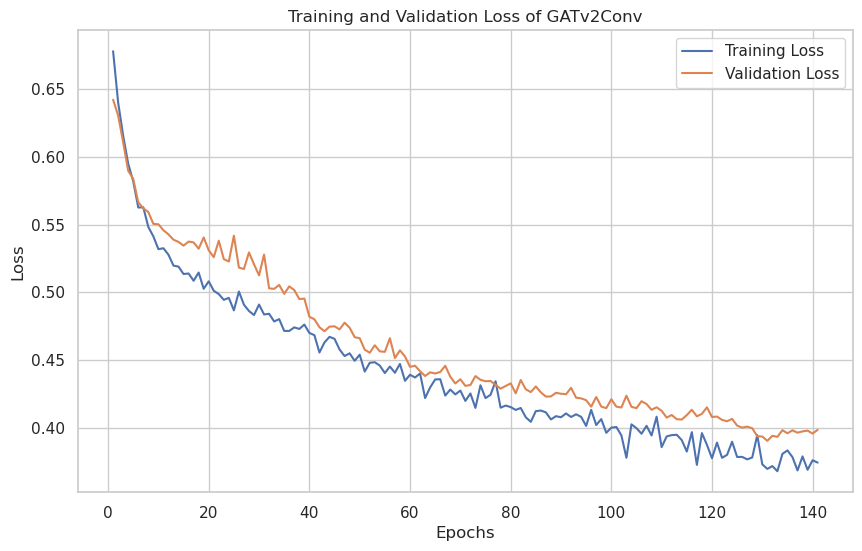

Completed training.



In [14]:
# 2. Retraining with best hyperparameters (on a larger train and val set)
print("Retraining with best hyperparameters...")
model = GraphClsGATv2(
    in_feats=74,  # Adjust this based on your dataset
    hidden_dim=best_hyperparams['hidden_dim'],
    num_heads=best_hyperparams['num_heads'],
    dropout_rate=best_hyperparams['dropout_rate'],
    negative_slope=best_hyperparams['negative_slope'],
    num_cls=2, 
).to(device)

print("")

# Reset model weights and biases parameters before retraining
model.reset_parameters()

optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['lr'])
criterion = nn.CrossEntropyLoss()

early_stopping = EarlyStopping(patience_loss=10, patience_accuracy=10, 
                               verbose=False, delta_loss=0.001, 
                               delta_accuracy=0.001, path='checkpoint.pt', 
                               print_freq=5)

training_pipeline = TrainingPipeline(device)

training_pipeline.train_and_evaluate(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    early_stopping,
    300,
    plot_curves=True)
optimal_epoch = early_stopping.best_epoch

# Before final training on the combined train and val dataset, reset the
# model weights and biases again
model.reset_parameters()
print("Completed training.")
print("")


## Train Model with Best Hyperparameters on whole train set



In [15]:
# 3. Final training on the combined train and val dataset
print("Final training on the combined train and val dataset...")
optimizer = optim.Adam(model.parameters(), lr=best_hyperparams['lr'])
criterion = nn.CrossEntropyLoss()

training_pipeline.train_and_evaluate(
    model,
    combined_train_loader,
    None,
    optimizer,
    criterion,
    None,
    optimal_epoch,
    plot_curves=False)

# save the model
torch.save(model.state_dict(), f'gatv2_model_run_{RUN_NUMBER}.pt')

print("Completed training.")
print("")


Final training on the combined train and val dataset...


Completed training.



## Evaluate the Model



Evaluating on the test set...


Test Loss: 0.3363354504108429
Accuracy: 0.8636942675159236, Precision: 0.8553615960099751, Recall: 0.875, F1-Score: 0.8650693568726356, ROC-AUC: 0.8637086513994912
Completed evaluation.


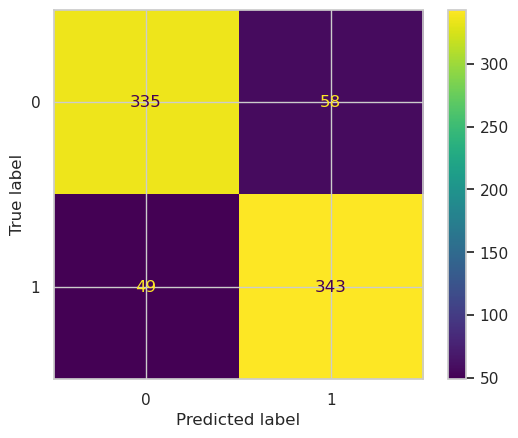

In [16]:

# Evaluation on the test set
print("Evaluating on the test set...")
training_pipeline.evaluate_on_test(model, test_loader, criterion, RUN_NUMBER)
print("Completed evaluation.")
